In [4]:
!pip install torch torchvision torchaudio torch-geometric pandas numpy rdkit scikit-learn tqdm optuna torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 50.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem, RDLogger
from rdkit.Chem import (
    AllChem, 
    Descriptors, 
    rdMolDescriptors, 
    Lipinski, 
    MolFromSmiles
)
from rdkit.Chem import rdFingerprintGenerator as fp
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.utils import degree

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error
)
from sklearn.model_selection import train_test_split

In [6]:
train_data = pd.read_csv('/kaggle/input/sibur-happiness/silly_aug.csv')
test_data = pd.read_csv('/kaggle/input/sibur119cava80/sibur_element_119_final_test_data80.csv')

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdmolops
import torch
from torch_geometric.data import Data
from tqdm.notebook import tqdm

def smiles_to_graph(smiles, logp=None):
    """Convert SMILES to molecular graph with error handling"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        print(f"Warning: Could not parse SMILES: {smiles}")
        return None
    
    try:
        Chem.SanitizeMol(mol)
    except:
        print(f"Warning: Sanitization failed for SMILES: {smiles}")
        return None
    
    atom_features_list = []
    edge_index = []
    edge_attr_list = []

    try:
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            
            edge_index.append((i, j))
            edge_index.append((j, i))
            
            bond_features = [
                float(bond.GetBondTypeAsDouble()),
                float(bond.GetIsConjugated()),
                float(bond.GetIsAromatic()),
                float(bond.IsInRing()),
            ]
            
            edge_attr_list.append(bond_features)
            edge_attr_list.append(bond_features)

        for atom in mol.GetAtoms():
            atom_features_list.append([
                float(atom.GetAtomicNum()),
                float(atom.GetDegree()),
                float(atom.GetFormalCharge()),
                float(atom.GetNumRadicalElectrons()),
                float(atom.GetHybridization()),
                float(atom.GetIsAromatic()),
                float(atom.GetTotalNumHs()),
                float(atom.GetMass() * 0.01)
            ])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
        x = torch.tensor(atom_features_list, dtype=torch.float)
        
        if logp is not None:
            return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([logp], dtype=torch.float))
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {str(e)}")
        return None

train_graphs = []
for s, logp in tqdm(zip(train_data['SMILES'], train_data['LogP']), total=len(train_data)):
    graph = smiles_to_graph(s, logp)
    if graph is not None:
        train_graphs.append(graph)

test_graphs = []
for s in tqdm(test_data['SMILES'], total=len(test_data)):
    graph = smiles_to_graph(s)
    if graph is not None:
        test_graphs.append(graph)

print(f"Processed {len(train_graphs)}/{len(train_data)} train molecules")
print(f"Processed {len(test_graphs)}/{len(test_data)} test molecules")

  0%|          | 0/28231 [00:00<?, ?it/s]

  0%|          | 0/2630 [00:00<?, ?it/s]

Processed 28231/28231 train molecules
Processed 2630/2630 test molecules


In [8]:
train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.3, random_state=42)

In [9]:
batch_size = 64
epochs = 200
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DMPNNLayer(MessagePassing):
    def __init__(self, hidden_size, edge_feat_dim):
        super().__init__(aggr='add')
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_size + edge_feat_dim, hidden_size),
            nn.ReLU()
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU()
        )

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        return self.edge_mlp(torch.cat([x_j, edge_attr], dim=-1))

    def update(self, aggr_out, x):
        return self.node_mlp(torch.cat([x, aggr_out], dim=-1))

class DMPNNModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, num_layers=6, edge_feat_dim=4):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        self.layers = nn.ModuleList([DMPNNLayer(hidden_size, edge_feat_dim) for _ in range(num_layers)])
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_size) for _ in range(num_layers)])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        
        x = self.initial(x)
        
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') else None

        for i, (layer, bn) in enumerate(zip(self.layers, self.bn_layers)):
            x = layer(x, edge_index, edge_attr)  # теперь передаём edge_attr
            x = bn(x)
            x = self.dropout(x)
            
        x = global_mean_pool(x, batch)
        return self.fc(x).squeeze(-1)

def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training'):
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return rmse, mae


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DMPNNModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = OneCycleLR(optimizer, max_lr=2e-3, 
                      steps_per_epoch=len(train_loader), 
                      epochs=epochs)
loss_fn = nn.MSELoss()

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch

best_rmse = float('inf')
best_model_weights = None

for epoch in range(1, 100 + 1):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_rmse, val_mae = evaluate(model, val_loader)
    scheduler.step()
    
    # Сохраняем модель, если достигнуто лучшее качество
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_weights = model.state_dict().copy()  
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
        }, 'best_model.pth')  
    
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f}")
    3
model.load_state_dict(best_model_weights)

AttributeError: 'MLPRegressor' object has no attribute 'train'

In [12]:
model.load_state_dict(best_model_weights)
print(evaluate(model, val_loader))

(1.394733, 0.75540674)


In [13]:
idd = pd.read_csv('/kaggle/input/sibur119cava80/sibur_element_119_final_test_data80.csv')

In [ ]:
def predict_and_save(model, test_graphs, idd, path):
    model.eval()
    preds = []
    test_loader = DataLoader(test_graphs, batch_size=64)
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Predicting LogP'):
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu().numpy())
    
    preds = np.concatenate(preds)
    
    df = pd.DataFrame({
        'LogP': preds
    })
    
    df.to_csv(path, index=False)
    print(f"Predictions saved to {path}")

In [ ]:
predict_and_save(model, test_graphs, idd, "submission_2.csv")
sub2 = pd.read_csv('submission_2.csv')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Predicting LogP:   0%|          | 0/42 [00:00<?, ?it/s]

Predictions saved to submission_2.csv


/kaggle/input/sibur-submission/final_sample_submission80 (5).csv
/kaggle/input/sibur-submission/final_sample_submission80 (6).csv
/kaggle/input/sibur-submission/subm_test_ann64-2.csv
/kaggle/input/sibur-submission/aug_5model.csv
/kaggle/input/sibur-submission/deepchem_logp_predictions (4) (1).csv
/kaggle/input/sibur-submission/final_sample_submission802 (1).csv
/kaggle/input/sibur-submission/deepchem_logp_predictions (3) (1).csv
/kaggle/input/sibur-submission/submis.csv
/kaggle/input/sibur-submission/final_sample_submission80 (9) (1).csv
/kaggle/input/sibur-submission/final_sample_submission80 (8) (1).csv
/kaggle/input/sibur-submission/submission (7) (1).csv


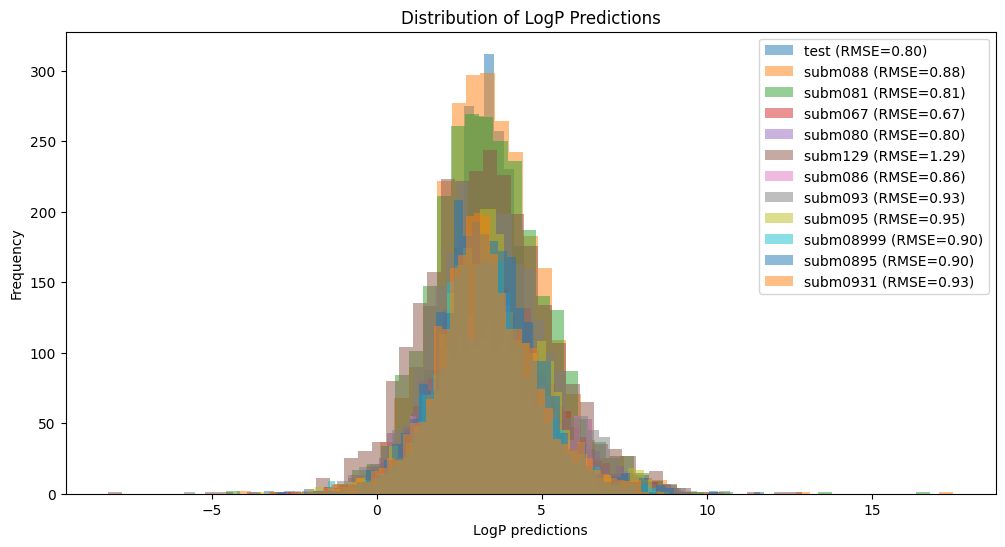

Train R2: 1.000
Test R2: 0.929
test: Predicted RMSE 0.930 | True RMSE 0.80 | Error 0.130
subm088: Predicted RMSE 0.884 | True RMSE 0.88 | Error 0.004
subm081: Predicted RMSE 0.805 | True RMSE 0.81 | Error 0.005
subm067: Predicted RMSE 0.670 | True RMSE 0.67 | Error 0.000
subm080: Predicted RMSE 0.801 | True RMSE 0.80 | Error 0.001
subm129: Predicted RMSE 1.290 | True RMSE 1.29 | Error 0.000
subm086: Predicted RMSE 0.862 | True RMSE 0.86 | Error 0.002
subm093: Predicted RMSE 0.930 | True RMSE 0.93 | Error 0.000
subm095: Predicted RMSE 0.951 | True RMSE 0.95 | Error 0.001
subm08999: Predicted RMSE 0.898 | True RMSE 0.90 | Error 0.002
subm0895: Predicted RMSE 0.895 | True RMSE 0.90 | Error 0.001
subm0931: Predicted RMSE 0.930 | True RMSE 0.93 | Error 0.001


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def load_submissions():
    submissions = []
    paths = [
        '/kaggle/input/sibur-submission/final_sample_submission80 (5).csv',
        '/kaggle/input/sibur-submission/final_sample_submission80 (6).csv',
        '/kaggle/input/sibur-submission/subm_test_ann64-2.csv',
        '/kaggle/input/sibur-submission/aug_5model.csv',
        '/kaggle/input/sibur-submission/deepchem_logp_predictions (4) (1).csv',
        '/kaggle/input/sibur-submission/final_sample_submission802 (1).csv',     #это просто загрузка данных, которые были у насЦ
        '/kaggle/input/sibur-submission/deepchem_logp_predictions (3) (1).csv',
        '/kaggle/input/sibur-submission/submis.csv',
        '/kaggle/input/sibur-submission/final_sample_submission80 (9) (1).csv',
        '/kaggle/input/sibur-submission/final_sample_submission80 (8) (1).csv',
        '/kaggle/input/sibur-submission/submission (7) (1).csv'
    ]
    submissions.append(sub2['LogP'].values)
    for path in paths:
        df = pd.read_csv(path)
        print(path)
        submissions.append(df['LogP'].values)
    return np.array(submissions)

submissions = load_submissions()
submission_names = ["test", "subm088","subm081", "subm067", "subm080", "subm129", "subm086", "subm093", "subm095", "subm08999", "subm0895", "subm0931"]
submission_values = np.array([0.8, 0.88, 0.81, 0.67, 0.80, 1.29, 0.86, 0.93, 0.95, 0.899882, 0.895315, 0.93088])  # RMSE значений

plt.figure(figsize=(12, 6))
for i, (name, preds) in enumerate(zip(submission_names, submissions)):
    plt.hist(preds, bins=50, alpha=0.5, label=f"{name} (RMSE={submission_values[i]:.2f})")
plt.xlabel("LogP predictions")
plt.ylabel("Frequency")
plt.title("Distribution of LogP Predictions")
plt.legend()
plt.show()

def extract_features(submission):
    features = [
        np.mean(submission),
        np.std(submission),
        np.min(submission),
        np.max(submission),
        np.median(submission),
        np.percentile(submission, 25),
        np.percentile(submission, 75),
        np.sum(submission < 0),  # count of negative predictions
        np.sum(submission > 1)   # count of predictions > 1
    ]
    return features

X = np.array([extract_features(sub) for sub in submissions])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = X_scaled[1:], X_scaled, submission_values[1:], submission_values

model = MLPRegressor(
    hidden_layer_sizes=(8,),  # 1 слой с 8 нейронами
    activation='tanh',        # tanh работает лучше для регрессии
    solver='lbfgs',          # лучше для маленьких датасетов
    alpha=1e-4,
    max_iter=500,
    random_state=42,
    early_stopping=False     # отключаем для малых данных
)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f"Train R2: {r2_score(y_train, train_pred):.3f}")
print(f"Test R2: {r2_score(y_test, test_pred):.3f}")

for name, sub, true_rmse in zip(submission_names, submissions, submission_values):
    features = extract_features(sub)
    features_scaled = scaler.transform([features])
    pred_rmse = model.predict(features_scaled)[0]
    print(f"{name}: Predicted RMSE {pred_rmse:.3f} | True RMSE {true_rmse:.2f} | Error {abs(pred_rmse-true_rmse):.3f}")

In [52]:
test_data.to_csv('XGB_DC_DMPNN_test.csv', index=False)